<div style="text-align:left;">

# <span style="text-decoration: underline;"><b>Projet de fin de formation - DATAGONG</b></span>

</div>


## <b>Analyse e‑commerce 2023 vs 2024 — thelook_ecommerce </b>

### Contexte & périmètre
Analyse de la performance e-commerce TheLook Europe sur le périmètre :
- Pays : France
- Département : Women
- Période : 01/01/2023 – 31/12/2024
- Objectif : comparer 2023 vs 2024 via une EDA et le calcul de KPI métier.


Objectifs de l’EDA

Cette analyse exploratoire vise à :
- comprendre la structure des ventes et des retours sur 2023–2024,
- identifier les dynamiques temporelles, produits et géographiques,
- repérer d’éventuelles ruptures ou anomalies,
avant toute formalisation définitive des indicateurs de performance.


### 1. Descriptions des variables

#### 1.1. Aperçu global du jeu de données et re-typage des données
Commençons par importer notre jeu de données sous format csv et le convertir en DataFrame.

In [1]:
import pandas as pd
import numpy as np
# Chargement du fichier csv
df = pd.read_csv("../data/thelook_fr_women_2023_2024.csv")

# Dimensions du jeu de données
print(f'Le jeu de données fait {df.shape[0]} lignes et {df.shape[1]} colonnes')

# En-tête du jeu de données
df.head()

Le jeu de données fait 1679 lignes et 20 colonnes


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
0,19425,28112,6983,2023-01-01 06:18:03+00:00,Shipped,29.500000,16.048000,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
1,19425,28113,10597,2023-01-01 06:44:58+00:00,Shipped,20.000000,10.000000,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
2,4710,6730,11792,2023-01-03 04:44:50+00:00,Complete,38.000000,18.468000,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris
3,16618,24006,329,2023-01-03 15:13:39+00:00,Complete,27.990000,16.402140,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,13422,F,France,Hauts-de-France,Comines
4,4710,6731,5295,2023-01-05 06:43:09+00:00,Complete,56.880001,29.577601,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris


Une fois notre DataFrame créé, intéressons-nous aux colonnes grâce à la méthode .info de pandas, puis nous allons créer ensuite un dictionnaire les décrivant (définition, type, exemple).

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          1679 non-null   int64  
 1   order_item_id     1679 non-null   int64  
 2   product_id        1679 non-null   int64  
 3   item_created_at   1679 non-null   object 
 4   item_status       1679 non-null   object 
 5   sale_price        1679 non-null   float64
 6   cost              1679 non-null   float64
 7   category          1679 non-null   object 
 8   department        1679 non-null   object 
 9   brand             1677 non-null   object 
 10  product_name      1679 non-null   object 
 11  order_status      1679 non-null   object 
 12  order_created_at  1679 non-null   object 
 13  shipped_at        1133 non-null   object 
 14  delivered_at      636 non-null    object 
 15  user_id           1679 non-null   int64  
 16  gender            1679 non-null   object 


On observe déjà que l'essentiel des valeurs manquantes se trouve dans les deux variables `shipped_at` et `delivered_at`, ce qui n'est pas surprenant si on considère qu'un certain nombre de commandes n'ont pas encore été expédiées et livrées au moment de l'extraction des bases.
Il existe également 2 valeurs manquantes pour la colonne brand.

On peut d'ores et déjà changer le type object en date pour les colonnes de date et en category pour les colonnes catégorielles . 

In [3]:
# Affichage des colonnes catégorielles
df.select_dtypes(include='object').head()

,item_created_at,item_status,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,gender,country,state,city
0,2023-01-01 06:18:03+00:00,Shipped,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
1,2023-01-01 06:44:58+00:00,Shipped,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
2,2023-01-03 04:44:50+00:00,Complete,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris
3,2023-01-03 15:13:39+00:00,Complete,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,F,France,Hauts-de-France,Comines
4,2023-01-05 06:43:09+00:00,Complete,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris


Les dates sont au format objet, ce qui n'est pas très pratique pour trier notre DataFrame.
Nous allons commencer par parser les dates.

In [4]:
# Colonnes de date 
col_dates = [
    "item_created_at", 
    "order_created_at", 
    "shipped_at", 
    "delivered_at"
]

# Formatage de la date 
for c in col_dates:
    dates = pd.to_datetime(df[c], errors='coerce')
    df[c] = dates

Maintenant que les dates sont parsées, nous allons déterminer pour quelles colonnes il faudrait typer en category.

In [5]:
# Nombre de modalités pour les colonnes object
for col in df.select_dtypes(include='object').columns.to_list():
    print(f'Colonne {col} : {df[col].nunique()}')

Colonne item_status : 5
Colonne category : 22
Colonne department : 1
Colonne brand : 657
Colonne product_name : 1559
Colonne order_status : 5
Colonne gender : 1
Colonne country : 1
Colonne state : 13
Colonne city : 547


 Les colonnes `brand` et `product_name` ont un nombre important de modalités uniques. Ainsi, nous les laisserons en format object.

 Changeons le type des autres colonnes catégorielles :

In [6]:
# Colonnes catégorielles
cat_list = [
    "item_status", 
    "category", 
    "department", 
    "order_status", 
    "gender", 
    "country", 
    "state", 
    "city"
]

# Changement des type object en category pour les variables catégorielles
df[cat_list] = df[cat_list].astype('category')

Finalement après toutes ces opérations, il est temps de re-contrôler le type de nos données.

In [7]:
# Contrôle du type des données
df.dtypes

order_id                          int64
order_item_id                     int64
product_id                        int64
item_created_at     datetime64[ns, UTC]
item_status                    category
sale_price                      float64
cost                            float64
category                       category
department                     category
brand                            object
product_name                     object
order_status                   category
order_created_at    datetime64[ns, UTC]
shipped_at          datetime64[ns, UTC]
delivered_at        datetime64[ns, UTC]
user_id                           int64
gender                         category
country                        category
state                          category
city                           category
dtype: object

Les colonnes de dates ont été parsées au format datetime. Les variables à faible cardinalité ont été typées en catégorie (item_status, category, order_status, state…), tandis que `brand` et `product_name` ont été conservées en object en raison de leur cardinalité élevée.
. On crée maintenant notre dictionnaire de données permettant de décrire les colonnes.

#### 1.2. Création du mini-dictionnaire de données
On va maintenant procéder à la création du du mini-dictionnaire des données.

**Grain du dataset**  
Chaque ligne du fichier correspond à **un article (ligne de commande)** associé :
- à une **commande** (`order_id`),
- à un **client** (`user_id`),
- à un **produit** (`product_id`).

Le fichier CSV est **fourni par l’équipe pédagogique** et correspond au sous-périmètre :
France × Women × 2023–2024.  
Il constitue la base unique de l’analyse exploratoire (EDA) en Python.

---

| Colonne | Type | Définition métier | Remarques |
|------|------|--------------------|-----------|
| `order_id` | int64 | Identifiant unique de la commande. | Une commande peut contenir plusieurs articles. |
| `order_item_id` | int64 | Identifiant unique de la ligne de commande (article). | Doit être unique. Sert à vérifier l’absence de doublons métier. |
| `product_id` | int64 | Identifiant unique du produit acheté. | – |
| `item_created_at` | datetime (UTC) | Date de création de la ligne de commande. | Date de référence pour le périmètre temporel. |
| `item_status` | category | Statut de la ligne de commande (ex. `Complete`, `Returned`). | – |
| `sale_price` | float64 | Prix de vente de l’article. | – |
| `cost` | float64 | Coût d’achat ou de fabrication du produit. | – |
| `category` | category | Catégorie du produit. | – |
| `department` | category | Département du produit (Women). | Variable constante dans le périmètre. |
| `brand` | object | Marque du produit. | – |
| `product_name` | object | Nom du produit. | – |
| `order_status` | category | Statut de la commande (ex. `Complete`, `Shipped`). | Statut global, distinct du statut des lignes. |
| `order_created_at` | datetime (UTC) | Date de création de la commande. | Utilisée pour les analyses au niveau commande. |
| `shipped_at` | datetime (UTC) | Date d’expédition de l’article. | Valeurs manquantes attendues. |
| `delivered_at` | datetime (UTC) | Date de livraison de l’article. | Valeurs manquantes attendues. |
| `user_id` | int64 | Identifiant unique du client. | Un client peut passer plusieurs commandes. |
| `gender` | category | Genre déclaré du client. | – |
| `country` | category | Pays de résidence du client. | Variable constante dans le périmètre. |
| `state` | category | Région / État du client. | – |
| `city` | category | Ville du client. | – |

---

**Notes méthodologiques**
- Le dataset est au **grain ligne de commande** (article), et non au niveau commande.
- Les colonnes logistiques (`shipped_at`, `delivered_at`) peuvent légitimement contenir des valeurs manquantes.


### 2. Contrôle de qualité des données

#### 2.1. Traitement des doublons
On va chercher dans un premier temps à voir s'il existe des observations intégralement dupliquées.

In [8]:
# Recherche d'observations intégralement dupliquées 
print(f"Il y a {df.duplicated().sum()} ligne(s) intégralement dupliquée(s)")

Il y a 0 ligne(s) intégralement dupliquée(s)


`order_item_id` étant la clé Métier, il est primordial de vérifier son unicité :

In [9]:
df['order_item_id'].is_unique
df['order_item_id'].duplicated().sum()

np.int64(0)

Nous constatons qu'il n'y a aucune ligne intégralement dupliquée et qu'aucun doublon n’est détecté sur order_item_id, ce qui confirme l’unicité des lignes de vente et la fiabilité des agrégations futures.

#### 2.2. Traitement des valeurs manquantes
On va maintenant chercher à savoir s'il existe des valeurs manquantes et comment les traiter. On a vu que pour certains champs comme `shipped_at` et `delivered_at` il était normal d'avoir des valeurs manquantes. Celles-ci n’affectent pas les analyses de performance (CA, marge, retours) car elles ne sont pas utilisées dans les calculs ultérieurs. 
Il sera préférable de les laisser simplement en NaT. 


On en observe en revanche deux dans le champ `brand`. Cherchons alors la meilleure méthode d'imputation pour ces deux observations. 

In [10]:
# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"].isna()]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Une première stratégie d'imputation serait de chercher si ces produits se retrouvent ailleurs dans le DataFrame et leur imputer la valeur de brand d'un hypothétique même produit.

In [11]:
# Identification des product_id dont la marque est manquante
missing_brand_products = df.loc[df["brand"].isna(), "product_id"].unique()

# Vérification de s'ils apparaissent ailleurs dans le dataset
df[df["product_id"].isin(missing_brand_products)]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Ces produits sont uniques, on ne peut donc pas imputer avec la valeur de brand hypothétique. On va donc se contenter de remplacer par *"missing"*.

In [12]:
# Imputation par missing
df.fillna({"brand": "missing"}, inplace=True)

# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"]=="missing"]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,missing,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,missing,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Les valeurs manquantes concernent principalement les dates de livraison et d’expédition, ce qui est cohérent avec des commandes non encore livrées ou annulées.
La variable `brand` comporte 2 valeurs manquantes sur 1 679 lignes
(soit 0,12 % du jeu de données). Ces valeurs ont été imputées
sous la modalité `"missing"` faute de plus d'informations. Cette proportion est jugée négligeable
et n’impacte pas les analyses exploratoires.


#### 2.3. Cohérence des bornes temporelles


L’analyse est réalisée au **grain ligne de commande (article)**.  
Il existe donc deux dates distinctes dans le dataset :
- la date de création de la commande (`order_created_at`),
- la date de création de la ligne de commande (`item_created_at`).

Dans un contexte e-commerce réel, ces deux dates peuvent différer.  
Par exemple, une commande peut être créée juste avant minuit, tandis que les lignes qui la composent sont enregistrées quelques secondes ou minutes plus tard, parfois après un changement de date (notamment en raison des fuseaux horaires ou de traitements techniques asynchrones).

Afin de respecter le **grain d’analyse** et le **périmètre temporel demandé**, le filtrage est donc effectué sur la date de création des lignes (`item_created_at`) et non sur la date de création des commandes.  
Ce choix permet d’éviter l’exclusion ou l’inclusion incorrecte de lignes situées à la frontière entre deux périodes. Nous pouvons ainsi créer les colonnes des mois et des années tirées de `item_created_at` :


In [13]:
# Création des colonnes year et month
df["year"] = df["item_created_at"].dt.year
df["month"] = df["item_created_at"].dt.month

In [14]:
# Définition des bornes temporelles
date_limits = {
    "avant 2023": "2023-01-01 00:00:00+00:00",
    "après 2024": "2025-01-01 00:00:00+00:00"
}

# Affichage des bornes min / max
print(
    f"La date la plus ancienne de item_created_at est : {df['item_created_at'].min()}\n"
    f"La date la plus récente de item_created_at est : {df['item_created_at'].max()}\n"
)

# Comptage des dates hors périmètre
for label, limit in date_limits.items():
    count = (
        (df["item_created_at"] < limit).sum()
        if "avant" in label
        else (df["item_created_at"] > limit).sum()
    )
    print(f"Colonne item_created_at : {count} dates {label}")

La date la plus ancienne de item_created_at est : 2023-01-01 06:18:03+00:00
La date la plus récente de item_created_at est : 2024-12-31 10:40:48+00:00

Colonne item_created_at : 0 dates avant 2023
Colonne item_created_at : 0 dates après 2024


Toutes les dates sont comprises entre 2023 et 2024, 
le périmètre temporel est respecté.


Pour terminer, nous contrôlons la cohérence chronologique des différentes
étapes du cycle de vie des commandes (création, expédition et livraison).
L’objectif est de détecter d’éventuelles incohérences temporelles et
d’évaluer leur impact sur les analyses exploratoires.


In [15]:
# Controle de la cohérence chronologique order_created_at < shipped_at
df[
    (df["shipped_at"].notna()) &
    (df["shipped_at"] < df["order_created_at"])
].shape[0]

0

In [16]:
# Contrôle de la cohérence chronologique shipped_at < delivered_at
mask_delivered = (
    df["delivered_at"].notna()
    & df["shipped_at"].notna()
    & (df["delivered_at"] < df["shipped_at"])
)

mask_delivered.sum()

np.int64(0)

Les contrôles de cohérence temporelle effectués sur les dates
d’expédition et de livraison ne révèlent aucune incohérence
chronologique sur les lignes concernées.

**Conclusion des contrôles de qualité**

Les contrôles effectués n’ont pas mis en évidence d’anomalies bloquantes.
Les valeurs manquantes observées concernent essentiellement des variables logistiques non utilisées dans les calculs de performance.
Les identifiants de lignes (`order_item_id`) sont uniques, garantissant la fiabilité des agrégations.
Les données sont jugées exploitables pour les analyses exploratoires et le calcul des KPI. La suite de l’analyse se concentre sur une exploration descriptive visant à caractériser la structure du chiffre d’affaires réalisé (ventes finalisées) selon le temps, les produits et la géographie.


### 3. Explorations descriptives

#### 3.1. Distribution des données de prix de vente et de coût
Les analyses de distribution portent sur l’ensemble des statuts afin de caractériser la structure des données. Par la suite, les analyses de contribution se concentreront sur les ventes finalisées (Complete).

Commençons tout d'abord par faire un contrôle qualité Métier rapide sur les prix de vente et les coûts. Ceux-ci ne doivent en aucun cas être négatifs, de plus le prix de vente doit toujours être supérieur au coût qui lui est associé.

In [18]:
# Contrôle Métier sur les colonnes prix de vente et coût
df[
    (df["sale_price"] <= 0) |
    (df["cost"] < 0) |
    (df["sale_price"] < df["cost"])
].shape[0]

0

Aucune valeur aberrante n’est observée sur les variables de prix et de coût.
Les prix de vente sont strictement positifs et supérieurs aux coûts associés,
ce qui sécurise les analyses ultérieures de performance.


Poursuivons avec la distribution des données liées aux prix de vente et au coût des produits. Utilisons pour cela la méthode describe().

In [19]:
# Méthode describe sur les colonnes prix de vente et coût
df[["sale_price", "cost"]].describe()

,sale_price,cost
count,1679.000000,1679.000000
mean,57.021769,27.460066
std,69.682245,31.854450
min,1.820000,0.749840
25%,19.990000,9.681000
50%,38.000000,18.230800
75%,68.000000,33.232345
max,903.000000,437.052001


Les statistiques descriptives montrent des ordres de grandeur cohérents avec une activité e-commerce de prêt-à-porter.
La distribution des prix et des coûts est asymétrique à droite, avec une médiane inférieure à la moyenne, traduisant la présence de quelques articles à prix plus élevés.
Les valeurs minimales sont strictement positives, ce qui ne suggère pas d’erreurs de saisie.
Les valeurs maximales élevées restent plausibles et ne justifient pas de traitement particulier à ce stade.
Les données sont jugées exploitables pour la suite de l’analyse.


Nous pouvons également représenter nos données avec un histogramme et ainsi avoir une meilleure idée de la structure des prix de vente/coûts.

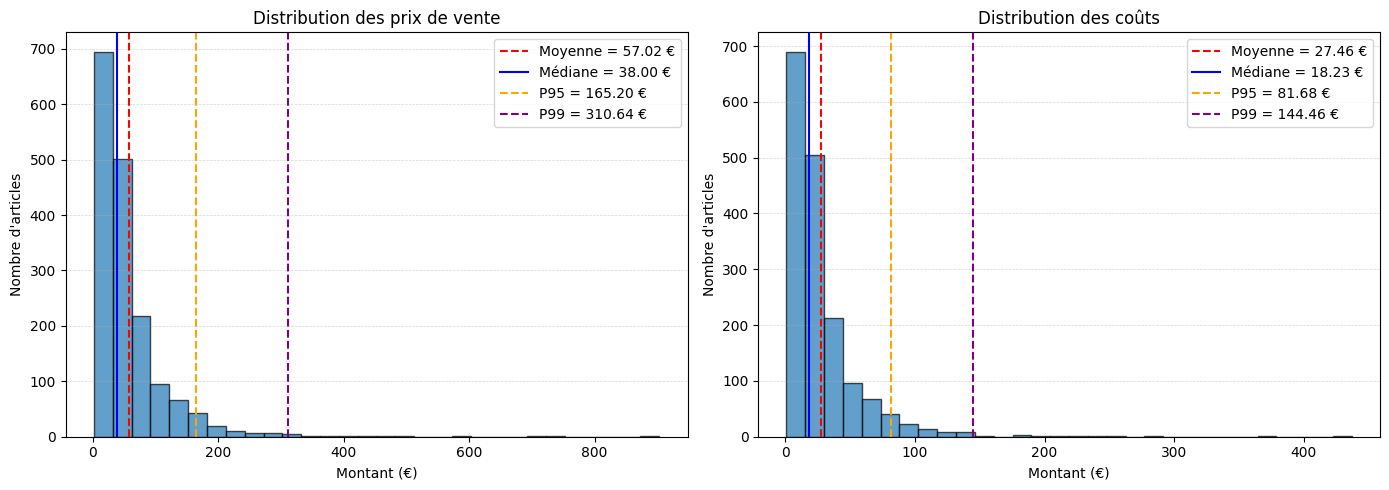

In [20]:
import matplotlib.pyplot as plt

# Titres
titles = {
    "sale_price": "Distribution des prix de vente",
    "cost": "Distribution des coûts"
}

# Colonnes
colonnes = ["sale_price", "cost"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, colonnes):
    # Sélection de la série
    x = df[col].dropna()

    # Statistiques de référence
    mean = x.mean()
    median = x.median()
    p95 = x.quantile(0.95)
    p99 = x.quantile(0.99)

    # Histogramme
    ax.hist(
        x,
        bins=30,
        edgecolor="black",
        alpha=0.7
    )

    # Lignes statistiques
    ax.axvline(mean, linestyle="--", color="red", label=f"Moyenne = {mean:.2f} €")
    ax.axvline(median, linestyle="-", color="blue", label=f"Médiane = {median:.2f} €")
    ax.axvline(p95, linestyle="--", color="orange", label=f"P95 = {p95:.2f} €")
    ax.axvline(p99, linestyle="--", color="purple", label=f"P99 = {p99:.2f} €")

    # Grille
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Titres et labels
    ax.set_title(titles[col])
    ax.set_xlabel("Montant (€)")
    ax.set_ylabel("Nombre d'articles")
    ax.legend()

plt.tight_layout()
plt.show()


Les distributions des prix de vente et des coûts présentent une forte asymétrie à droite.  
La majorité des articles se situe sur des niveaux de prix relativement faibles, tandis qu’un nombre limité d’articles affiche des valeurs très élevées, générant une longue traîne. Cette asymétrie se reflète dans l’écart marqué entre la moyenne et la médiane, la moyenne étant tirée vers le haut par les valeurs extrêmes.

**Interprétation métier**

Ces distributions suggèrent un catalogue composé majoritairement de produits à prix accessibles, complété par une offre plus restreinte de produits premium. Les articles à prix élevé, bien que peu nombreux, peuvent jouer un rôle disproportionné dans le chiffre d’affaires et la marge.


**Répartition des statuts de lignes de commande**

Afin de compléter cette première exploration globale, il est utile d’examiner la répartition des lignes selon leur statut, afin de mieux comprendre la structure opérationnelle du dataset.

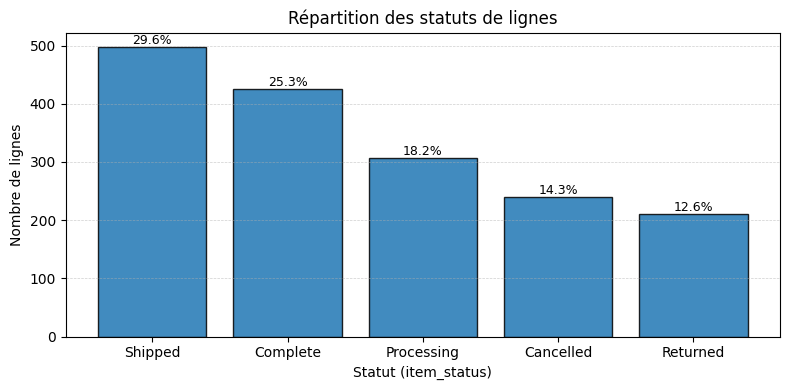

In [21]:
# Comptage des lignes par statut
counts = df["item_status"].value_counts()

# Calcul des parts relatives
pct = (counts / counts.sum() * 100).round(1)

# Construction du graphique
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(counts.index.astype(str), counts.values, edgecolor="black", alpha=0.85)

# Ajout des annotations (%)
for i, (c, p) in enumerate(zip(counts.values, pct.values)):
    ax.text(i, c, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

# Mise en forme et affichage
ax.set_title("Répartition des statuts de lignes")
ax.set_xlabel("Statut (item_status)")
ax.set_ylabel("Nombre de lignes")
ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()


Le graphique ci-dessus présente la distribution des lignes de commande selon leur statut (item_status) sur l’ensemble du dataset. La part importante de statuts non finaux (Shipped/Processing) confirme que les KPI doivent être calculés sur des statuts strictement définis (Complete pour le CA, Returned+Complete pour les retours) afin d’éviter tout biais.

**Conventions d’analyse pour les ventes réalisées**

À partir de cette section, les analyses se concentrent exclusivement sur les lignes correspondant à des ventes effectivement réalisées. Une ligne de commande est considérée comme une vente réalisée uniquement lorsque son statut est "Complete". Les statuts "Processing", "Shipped" et "Cancelled" correspondent à des étapes intermédiaires ou annulées du cycle de commande et ne garantissent pas la réalisation effective du revenu ; ils sont donc exclus des analyses présentées dans la suite de cette section. Dans la suite du notebook, “CA réalisé” désigne systématiquement la somme des sale_price des lignes au statut "Complete".

#### 3.2. Contribution par marque, catégorie, ville, saisonnalité mensuelle 
Maintenant nous allons nous intéresser à la contribution au CA effectivement réalisé sur 2023-2024 des marques, catégories, zones géographiques et selon le mois de l'année. Dans ce projet, le chiffre d’affaires réalisé est défini comme la somme des sale_price des lignes au statut "Complete" (voir convention du projet).
Les graphiques suivants présentent la contribution des principales marques,
catégories et villes au chiffre d’affaires total du périmètre.


##### 3.2.1. Contribution par marque

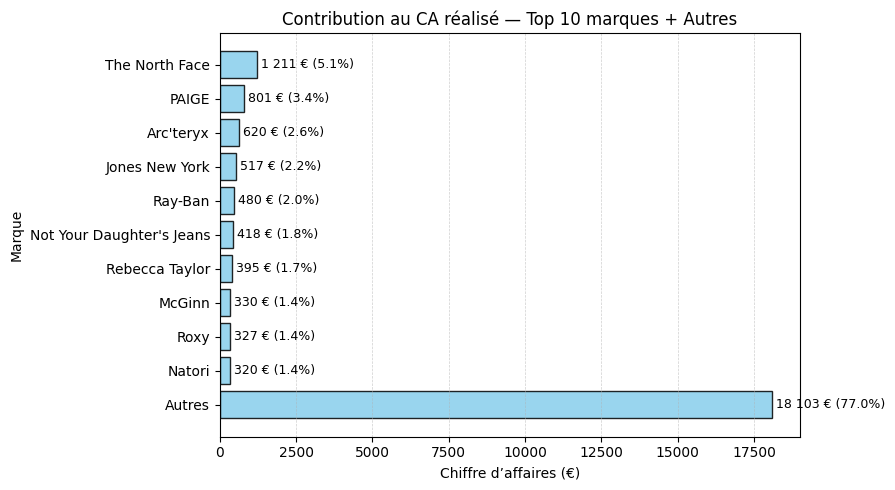

In [22]:
N = 10

# Filtre sur les articles au statut "Complete"
df_real = df[df["item_status"] == "Complete"].copy()

# Agrégation du chiffre d'affaires par marque
ca_brand = df_real.groupby("brand")["sale_price"].sum().sort_values(ascending=False)

# Sélection du Top N et agrégation du reste
top = ca_brand.head(N)
others = ca_brand.iloc[N:].sum()

# Construction de la série finale (Top N + Autres)
series = pd.concat([top, pd.Series({"Autres": others})])

# Calcul des parts relatives
share = (series / series.sum() * 100).round(1)

# Construction du graphique
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(series.index.astype(str), series.values, color="skyblue", edgecolor="black", alpha=0.85)
ax.invert_yaxis()

# Ajout des annotations (montant + %)
for i, (v, s) in enumerate(zip(series.values, share.values)):
    ax.text(v, i, f" {v:,.0f} € ({s:.1f}%)".replace(",", " "), va="center", fontsize=9)

# Mise en forme et affichage
ax.set_title(f"Contribution au CA réalisé — Top {N} marques + Autres")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Marque")
ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()


Les 10 premières marques ne représentent qu’environ 23 % du chiffre d’affaires total, ce qui met en évidence une forte fragmentation du portefeuille marques. 
La marque *The North Face* se distingue nettement comme le principal contributeur, suivie par *PAIGE* et *Arc'teryx. L’écart entre les premières marques et le bas du top 10 reste significatif, ce qui met en évidence une distribution inégale du chiffre d’affaires par marque.

**Interprétation métier**

Le portefeuille marques est fortement fragmenté : la majorité du chiffre d’affaires est réalisée au-delà du Top 10. Certaines marques ressortent toutefois comme principaux contributeurs et constituent des leviers de pilotage (assortiment, mise en avant), sans pour autant traduire une dépendance structurelle à un petit nombre de marques.


##### 3.2.2. Contribution par catégorie

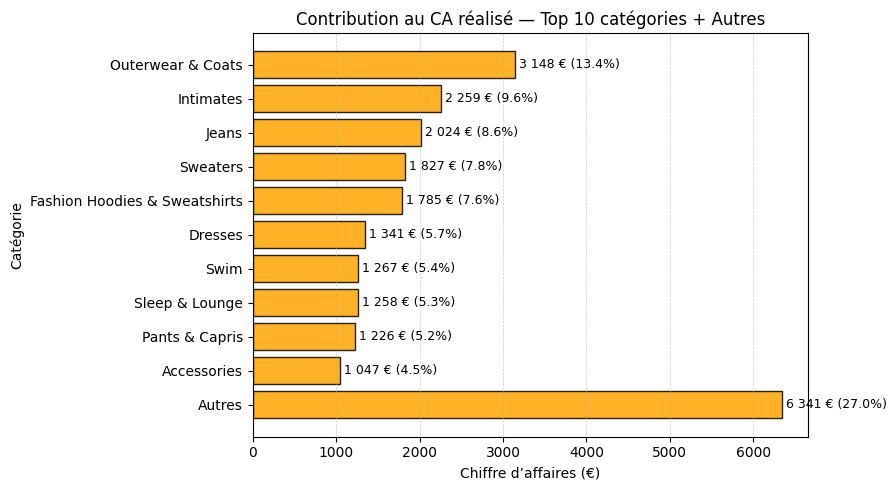

In [23]:
N = 10

# Agrégation du chiffre d'affaires par catégorie
ca_cat = df_real.groupby("category", observed=False)["sale_price"].sum().sort_values(ascending=False)

# Sélection du Top N et agrégation du reste
top = ca_cat.head(N)
others = ca_cat.iloc[N:].sum()

# Construction de la série finale (Top N + Autres)
series = pd.concat([top, pd.Series({"Autres": others})])

# Calcul des parts relatives
share = (series / series.sum() * 100).round(1)

# Construction du graphique
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(series.index.astype(str), series.values, color="orange", edgecolor="black", alpha=0.85)
ax.invert_yaxis()

# Ajout des annotations (montant + %)
for i, (v, s) in enumerate(zip(series.values, share.values)):
    ax.text(v, i, f" {v:,.0f} € ({s:.1f}%)".replace(",", " "), va="center", fontsize=9)

# Mise en forme et affichage
ax.set_title(f"Contribution au CA réalisé — Top {N} catégories + Autres")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Catégorie")
ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

Le chiffre d’affaires est majoritairement généré par quelques catégories clés.  
La catégorie *Outerwear & Coats* apparaît comme le principal contributeur, suivie par *Intimates* et *Jeans*. L’écart progressif observé entre les catégories souligne une hiérarchisation claire des familles de produits en termes de performance commerciale.

**Interprétation métier**

Ces résultats indiquent que la performance repose principalement sur un nombre limité de catégories clés, qui structurent l’essentiel du chiffre d’affaires réalisé sur le périmètre étudié.


##### 3.2.3. Contribution par ville

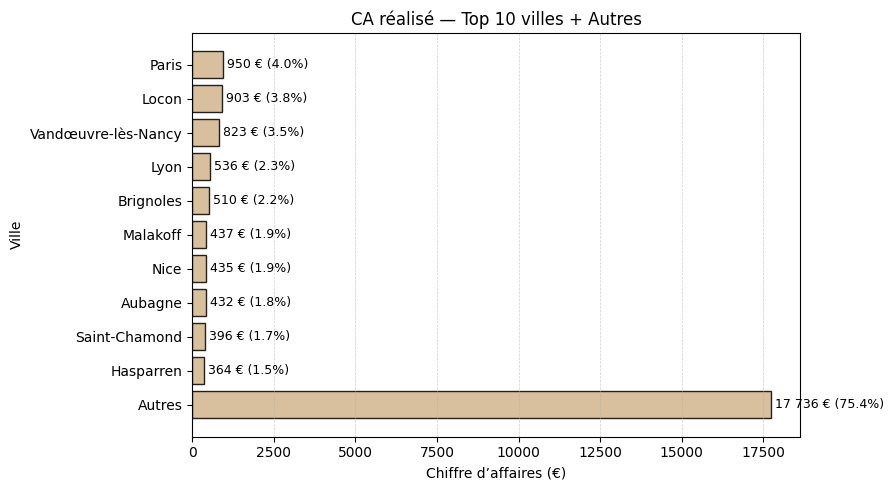

In [24]:
N = 10

# Agrégation du chiffre d'affaires par ville
ca_city = df_real.groupby("city", observed=False)["sale_price"].sum().sort_values(ascending=False)

# Sélection du Top N et agrégation du reste
top = ca_city.head(N)
others = ca_city.iloc[N:].sum()

# Construction de la série finale (Top N + Autres)
series = pd.concat([top, pd.Series({"Autres": others})])

# Calcul des parts relatives
share = (series / series.sum() * 100).round(1)

# Construction du graphique
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(series.index.astype(str), series.values, color="tan", edgecolor="black", alpha=0.85)
ax.invert_yaxis()

# Ajout des annotations (montant + %)
for i, (v, s) in enumerate(zip(series.values, share.values)):
    ax.text(v, i, f" {v:,.0f} € ({s:.1f}%)".replace(",", " "), va="center", fontsize=9)

# Mise en forme et affichage
ax.set_title(f"CA réalisé — Top {N} villes + Autres")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Ville")
ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()


Le chiffre d’affaires est géographiquement fragmenté : les 10 premières villes ne représentent qu’environ 24,6 % du chiffre d’affaires total, et Paris ne pèse que 4,0 %. La majorité du CA (75,4 %) est réalisée dans une longue traîne de villes, ce qui suggère une demande répartie sur l’ensemble du territoire plutôt qu’une dépendance à quelques grandes agglomérations.

**Interprétation métier**

La contribution géographique est fragmentée, la majorité du chiffre d’affaires étant réalisée hors des principales villes. La performance repose ainsi sur une base de clientèle largement répartie sur le territoire.


Afin de compléter l’analyse du chiffre d’affaires par ville et de neutraliser l’effet de taille des zones géographiques, le chiffre d’affaires est ici rapporté au nombre de clients distincts par ville.

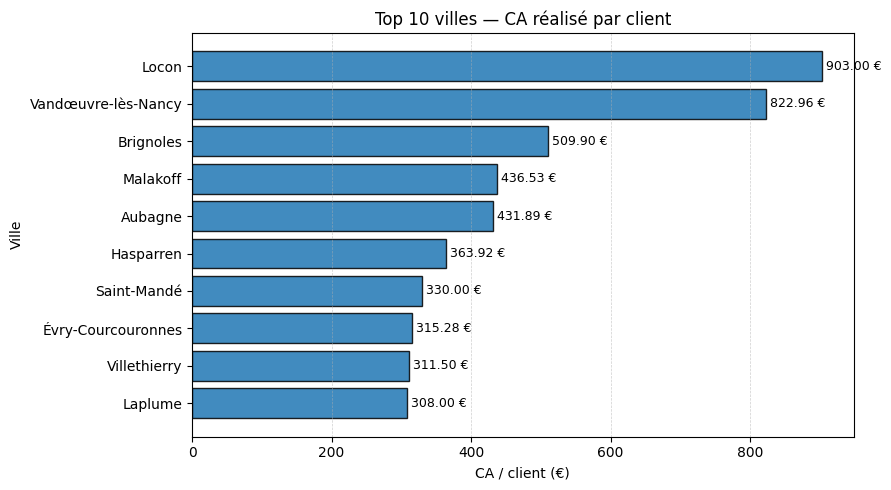

In [25]:
# Agrégation du CA et du nombre de clients par ville
city_kpis = df_real.groupby("city", observed=False).agg(
    ca=("sale_price", "sum"),
    clients=("user_id", "nunique")
)

# Calcul du CA par client
city_kpis["ca_par_client"] = city_kpis["ca"] / city_kpis["clients"]

# Sélection du Top 10 villes
topN = city_kpis.sort_values("ca_par_client", ascending=False).head(10)

# Construction du graphique
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(topN.index.astype(str), topN["ca_par_client"].values, edgecolor="black", alpha=0.85)
ax.invert_yaxis()

# Ajout des annotations
for i, v in enumerate(topN["ca_par_client"].values):
    ax.text(v, i, f" {v:.2f} €", va="center", fontsize=9)

# Mise en forme et affichage
ax.set_title("Top 10 villes — CA réalisé par client")
ax.set_xlabel("CA / client (€)")
ax.set_ylabel("Ville")
ax.grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()


Cette approche met en évidence des villes présentant un niveau de dépense moyenne par client plus élevé, indépendamment de leur volume de clientèle, et complète ainsi l’analyse basée sur les montants agrégés.

##### 3.2.4. Contribution par saisonnalité mensuelle

Nous allons maintenant créer une colonne month pour analyser la saisonnalité mensuelle. La saisonnalité mensuelle est analysée en agrégeant les ventes des années 2023 et 2024 afin de faire ressortir le profil saisonnier global du périmètre étudié.

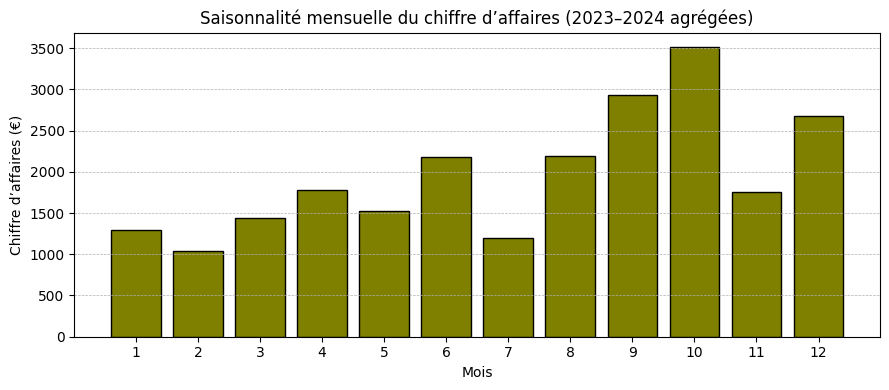

In [26]:
# Création colonne mois pour df_real
df_real["month"] = df_real["item_created_at"].dt.month

# Agrégation mensuelle du chiffre d'affaires
seasonality = (
    df_real.groupby("month")["sale_price"]
       .sum()
       .reindex(range(1, 13), fill_value=0)
)

# Construction du bar chart
fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(seasonality.index, seasonality.values, color="olive", edgecolor="black")

# Mise en forme et affichage
ax.set_xticks(range(1, 13))
ax.set_title("Saisonnalité mensuelle du chiffre d’affaires (2023–2024 agrégées)")
ax.set_xlabel("Mois")
ax.set_ylabel("Chiffre d’affaires (€)")
ax.grid(True, axis="y", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


L’analyse de la contribution mensuelle met en évidence une saisonnalité marquée du chiffre d’affaires réalisé.  
Les mois d’avril, juin, août, septembre, octobre et décembre apparaissent comme les plus contributifs, avec un pic notable en fin d’année. À l’inverse, certains mois comme février ou juillet présentent des niveaux de chiffre d’affaires plus faibles.

**Interprétation métier**

Cette saisonnalité est cohérente avec des comportements d’achat liés aux cycles de consommation dans le prêt-à-porter (renouvellement de garde-robe, périodes promotionnelles, achats de fin d’année). Cette analyse est réalisée sur les ventes finalisées (Complete) et reflète donc le chiffre d’affaires réalisé.


#### 3.3 Analyse de la marge et de la rentabilité

##### 3.3.1. Marge unitaire – distribution

Après avoir analysé la structure des prix et des coûts, puis la contribution au chiffre d’affaires, cette section vise à étudier la rentabilité du périmètre à travers l’analyse de la marge et du taux de marge, afin d’identifier les segments créateurs de valeur. Dans ce projet, la marge (ou marge brute) est définie comme sale_price – cost au niveau ligne.

In [27]:
# Création des métriques de marge
df_real["marge"] = df_real["sale_price"] - df_real["cost"]
df_real["taux_marge"] = df_real["marge"] / df_real["sale_price"]

# Statistiques descriptives
df_real[["marge", "taux_marge"]].describe()

,marge,taux_marge
count,425.000000,425.000000
mean,28.729295,0.512527
std,38.437359,0.067113
min,1.070160,0.350000
25%,9.450090,0.460000
50%,18.468000,0.514000
75%,31.297000,0.568000
max,465.947999,0.669000


La distribution des marges unitaires est asymétrique, avec une majorité d’articles générant une marge modérée et une longue traîne de produits à forte contribution. Le taux de marge moyen est cohérent avec le taux global observé (~52 %), confirmant la qualité des données de coût.

##### 3.3.2. Contribution à la marge totale par catégorie

Après avoir analysé la distribution globale des marges unitaires, cette section vise à identifier les catégories de produits qui contribuent le plus à la marge totale du périmètre. L’objectif est de comparer cette hiérarchisation à celle observée pour le chiffre d’affaires, afin de détecter d’éventuels effets de mix ou de rentabilité différenciée selon les familles de produits.

In [28]:
# Marge totale par catégorie
marge_cat = (
    df_real
    .groupby("category", observed=False)["marge"]
    .sum()
    .sort_values(ascending=False)
)

# Top 10 + autres
top = marge_cat.head(10)
others = marge_cat.iloc[10:].sum()
series = pd.concat([top, pd.Series({"Autres": others})])

# Parts relatives
share = (series / series.sum() * 100).round(1)


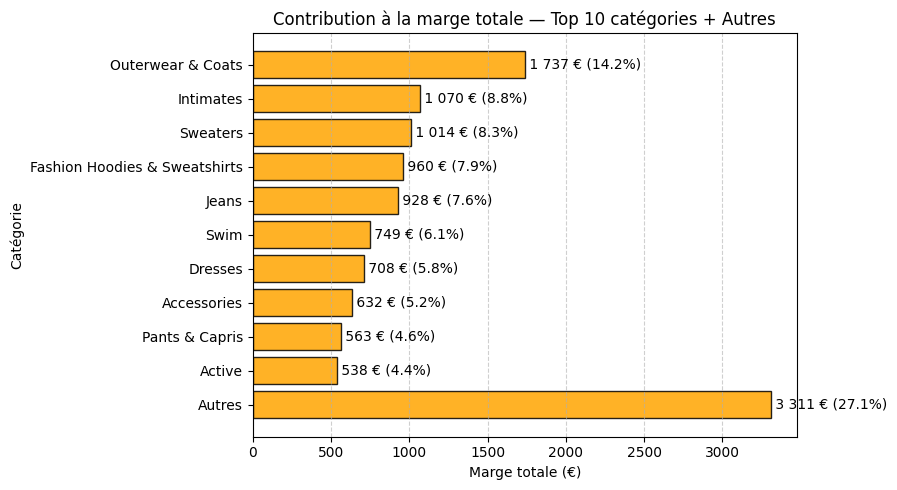

In [29]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(series.index.astype(str), series.values, color="orange", edgecolor="black", alpha=0.85)
ax.invert_yaxis()

for i, (v, s) in enumerate(zip(series.values, share.values)):
    ax.text(v, i, f" {v:,.0f} € ({s:.1f}%)".replace(",", " "), va="center")

ax.set_title("Contribution à la marge totale — Top 10 catégories + Autres")
ax.set_xlabel("Marge totale (€)")
ax.set_ylabel("Catégorie")
ax.grid(True, axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


La marge totale est principalement concentrée sur un nombre limité de catégories. Outerwear & Coats apparaît comme le premier contributeur à la marge, représentant environ 14 % de la marge totale, suivi par Intimates et Sweaters. À l’inverse, la catégorie “Autres” concentre à elle seule plus d’un quart de la marge totale, traduisant une longue traîne de catégories à contribution individuelle limitée mais significative collectivement.

**Interprétation métier**

Cette répartition souligne que la performance économique du périmètre ne repose pas uniquement sur les catégories leaders en chiffre d’affaires. Certaines catégories très visibles en volume génèrent proportionnellement moins de marge, tandis qu’une part importante de la rentabilité est issue d’une multitude de catégories secondaires. Cela justifie un pilotage combiné du chiffre d’affaires et de la marge, notamment dans les décisions d’assortiment et de mise en avant produit.

##### 3.3.3. Taux de marge par catégorie

Après avoir analysé la contribution absolue des catégories à la marge totale, cette section vise à neutraliser l’effet de volume afin d’évaluer la rentabilité relative des différentes familles de produits. L’objectif est d’identifier les catégories structurellement plus rentables, indépendamment de leur poids dans le chiffre d’affaires ou la marge globale.

In [30]:
taux_marge_cat = (
    df_real
    .groupby("category", observed=False)
    .agg(
        marge_totale=("marge", "sum"),
        ca_total=("sale_price", "sum")
    )
)

taux_marge_cat["taux_marge"] = (
    taux_marge_cat["marge_totale"] / taux_marge_cat["ca_total"]
)

taux_marge_cat = taux_marge_cat["taux_marge"].sort_values(ascending=False)

taux_marge_cat.head(10)

category
Blazers & Jackets                0.618261
Accessories                      0.603458
Skirts                           0.603390
Swim                             0.590816
Socks & Hosiery                  0.589802
Active                           0.559270
Sweaters                         0.554881
Maternity                        0.553222
Outerwear & Coats                0.551908
Fashion Hoodies & Sweatshirts    0.538050
Name: taux_marge, dtype: float64

L’analyse du taux de marge par catégorie met en évidence des écarts significatifs de rentabilité relative entre les familles de produits. Certaines catégories, telles que Blazers & Jackets, Accessories ou Skirts, affichent des taux de marge élevés (supérieurs à 60 %) tout en contribuant de manière limitée à la marge totale en raison de volumes plus faibles.

À l’inverse, des catégories comme Outerwear & Coats, fortement contributrices à la marge totale, présentent un taux de marge plus modéré, suggérant un effet volume dominant. Cette distinction entre rentabilité relative et contribution absolue souligne l’intérêt d’un pilotage différencié des catégories selon qu’elles constituent des leviers de croissance du volume ou d’optimisation de la rentabilité.

### 4. Comparaison 2023 vs 2024

A présent, voyons l'évolution mensuelle des ventes sur les années 2023 et 2024. L’analyse mensuelle permet de mettre en évidence la saisonnalité et d’identifier les périodes qui contribuent le plus aux écarts de performance entre 2023 et 2024. Comme avant, les analyses portent exclusivement sur les lignes de vente finalisées (statut Complete), afin de décrire la performance e-commerce réellement réalisée sur le périmètre.

Toutes les analyses temporelles comparatives 2023 vs 2024 seront basées sur item_created_at (date des lignes) comme vu auparavant.

In [31]:
# Evaluation du CA par année
df_real.groupby("year")["sale_price"].sum()

year
2023     7806.319998
2024    15716.280016
Name: sale_price, dtype: float64

Tout d'abord on remarque rapidement que ce chiffre d'affaires réalisé a significativement augmenté en 2024 par rapport à 2023. Regardons à présent le détail mois par mois.

In [32]:
# Création du dataframe regroupant les ventes par mois et années
monthly_ca = (
    df_real.groupby(["year", "month"])["sale_price"]
    .sum()
    .reset_index()
)

# Basculement du dataframe regroupant les ventes par mois et années
monthly_ca_pivot = monthly_ca.pivot(
    index="month",
    columns="year",
    values="sale_price"
)
monthly_ca_pivot

year,2023,2024
month,,
1,379.060003,920.759998
2,273.110003,771.389997
3,282.139999,1153.249990
4,743.299998,1031.020017
5,641.709999,880.730000
6,447.300000,1732.519998
7,384.859993,812.279997
8,863.260000,1332.590012
9,1169.070000,1761.389992


Nous avons une table représentant l'évolution mensuelle des ventes. Nous pouvons rajouter le différentiel mois à mois entre les deux années.

In [33]:
# Ajout de la variation absolue de chiffre d'affaires mois à mois
monthly_ca_pivot["delta_abs"] = (
    monthly_ca_pivot[2024]
    - monthly_ca_pivot[2023]
)

# Ajout de la variation relative de chiffre d'affaires mois à mois
monthly_ca_pivot["delta_pct"] = (
    (monthly_ca_pivot[2024] - monthly_ca_pivot[2023])
    / monthly_ca_pivot[2023]
)

monthly_ca_pivot

year,2023,2024,delta_abs,delta_pct
month,,,,
1,379.060003,920.759998,541.699995,1.429061
2,273.110003,771.389997,498.279994,1.824466
3,282.139999,1153.249990,871.109990,3.087510
4,743.299998,1031.020017,287.720018,0.387085
5,641.709999,880.730000,239.020001,0.372474
6,447.300000,1732.519998,1285.219998,2.873284
7,384.859993,812.279997,427.420004,1.110586
8,863.260000,1332.590012,469.330011,0.543672
9,1169.070000,1761.389992,592.319992,0.506659


Il serait maintenant intéressant d'afficher le tout sur un graphe de manière à mieux visualiser les pics ou creux.

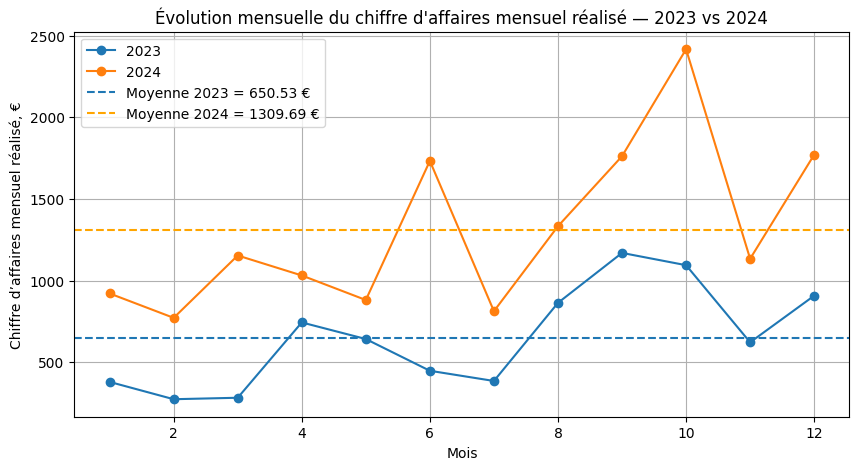

In [34]:
# Création du graphique des CA mensuels 2023 vs 2024
ax = monthly_ca_pivot[[2023, 2024]].plot(
    kind="line",
    marker="o",
    figsize=(10, 5)
)

# Calcul des moyennes annuelles
mean_2023 = monthly_ca_pivot[2023].mean()
mean_2024 = monthly_ca_pivot[2024].mean()

# Ajout des lignes horizontales correspondant aux moyennes
ax.axhline(mean_2023, linestyle="--", label=f"Moyenne 2023 = {mean_2023:.2f} €")
ax.axhline(mean_2024, linestyle="--", color='orange', label=f"Moyenne 2024 = {mean_2024:.2f} €")

# Paramétrage du graphique
ax.set_title("Évolution mensuelle du chiffre d'affaires mensuel réalisé — 2023 vs 2024")
ax.set_xlabel("Mois")
ax.set_ylabel("Chiffre d’affaires mensuel réalisé, €")

# Affichage de la légende et de la grille
ax.legend()
ax.grid(True)

# Affichage plot
plt.show()

La comparaison mensuelle met en évidence une dynamique globalement plus favorable en 2024.  
Sur la majorité des mois, le chiffre d’affaires réalisé de 2024 dépasse celui de 2023, avec des écarts particulièrement marqués au printemps et à l’automne. Les moyennes mensuelles confirment cette tendance, avec un niveau moyen plus élevé en 2024 qu’en 2023.

**Interprétation métier**

Cette évolution suggère une croissance de l’activité en 2024 sur le périmètre étudié, sous réserve de la stabilité des règles de calcul et du périmètre. Les mois d’octobre et de fin d’année apparaissent comme des périodes clés de création de valeur sur le périmètre étudié.


Synthèse de l’EDA

Cette analyse exploratoire met en évidence sur le périmètre étudié :
- des différences marquées entre 2023 et 2024,
- une structuration du chiffre d’affaires autour de certains segments produits,
- des dynamiques temporelles marquées et une répartition géographique fragmentée.

Après cette phase exploratoire, les indicateurs clés sont maintenant calculés de manière formalisée, selon des définitions métier explicites, afin de permettre une comparaison robuste entre 2023 et 2024 et une reprise directe dans le reporting.


### 5. KPI Python

Pour conclure l’EDA Python, nous calculons et présentons quelques indicateurs clés de la performance globale.
Comme avant, nous parlerons de CA réalisé. C’est-à-dire que les lignes de commande au statut autre que "Complete" seront exclues du calcul.

**Chiffre d’affaires réalisé** : somme des sale_price des lignes au statut "Complete".

In [35]:
# Calcul du chiffre d'affaires
ventes = df[df["item_status"] == "Complete"]
ca_total = ventes.groupby("year")["sale_price"].sum()

# Affichage du chiffre d'affaires
print("=== Chiffre d'affaires par année ===")

for annee, ca in ca_total.items():
    print(f" {annee} : {ca:.2f} €")

=== Chiffre d'affaires par année ===
 2023 : 7806.32 €
 2024 : 15716.28 €


**Marge brute** : somme des sale_price – cost des lignes au statut "Complete".

In [36]:
# Calcul de la marge brute
cost_total = ventes.groupby("year")["cost"].sum()
marge_brute = ca_total - cost_total

# Affichage de la marge brute
print("=== Marge brute par année ===")

for annee, mb in marge_brute.items():
    print(f"{annee} : {mb:.2f} €")

=== Marge brute par année ===
2023 : 4075.34 €
2024 : 8134.61 €


**Panier moyen** : Afin de contextualiser l’interprétation du panier moyen, un contrôle préalable est réalisé sur la structure des commandes.  
Le panier moyen étant calculé à l’échelle de la commande (`order_id`), il est nécessaire de comprendre combien d’articles composent généralement une commande et si la structure des statuts peut influencer cet indicateur.

In [ ]:
# Nombre de lignes par commande
items_per_order = df.groupby("order_id")["order_item_id"].count()
items_per_order.describe()

count    1117.000000
mean        1.503133
std         0.848380
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: order_item_id, dtype: float64

In [38]:
# Nombre de statuts distincts par commande
df.groupby("order_id")["item_status"].nunique().value_counts()

item_status
1    1117
Name: count, dtype: int64

La distribution du nombre de lignes par commande montre que la majorité des commandes contient un seul article (médiane = 1), avec une proportion plus limitée de commandes multi-articles (75 % ≤ 2 articles, maximum observé = 4). Cette structure (majorité de paniers à 1 article) implique que les variations de panier moyen proviendront principalement du prix moyen par article plutôt que d’un effet ‘quantité d’articles'.

Par ailleurs, l’analyse des statuts au sein des commandes indique que chaque commande présente un statut unique au niveau des lignes. Dans la suite de l’analyse, une commande sera considérée comme génératrice de revenu dès lors qu’elle contient **au moins une ligne au statut "Complete"**, ce qui est cohérent avec la structure observée des données.


In [39]:
# Filtre sur les ventes réalisées
sales = df[df["item_status"] == "Complete"].copy()

# Chiffre d'affaires réalisé par année
ca = sales.groupby("year")["sale_price"].sum()

# Nombre de commandes distinctes ayant généré du revenu
nb_orders = sales.groupby("year")["order_id"].nunique()

# Calcul du panier moyen et arrondi au centime
panier_moyen = (ca / nb_orders).round(2)

# Affichage du panier moyen
print("=== Panier moyen par année ===")

for annee, pm in panier_moyen.items():
    print(f"{annee} : {pm:.2f} €")

=== Panier moyen par année ===
2023 : 80.48 €
2024 : 85.41 €


**Taux de retour** :
Le taux de retour est défini comme la proportion de lignes retournées parmi les lignes effectivement vendues.
Une ligne est considérée comme vendue si son statut est "Complete" ; les lignes au statut "Returned" correspondent à des ventes ayant fait l’objet d’un retour.
Les statuts "Processing", "Shipped" et "Cancelled" sont exclus du calcul car ils ne garantissent pas la réalisation effective du revenu.
Le calcul est effectué au grain ligne de commande (order_item).

In [40]:
# Lignes vendues + retournées
ventes_retour = df[df["item_status"].isin(["Returned", "Complete"])]

taux_retour_par_an = (
    ventes_retour.assign(is_return=ventes_retour["item_status"] == "Returned")
    .groupby("year")["is_return"]
    .mean()
)

# Affichage du taux de retour
print("=== Taux de retour par année ===")

for annee, tr in taux_retour_par_an.items():
    print(f"{annee} : {tr*100:.2f} %")

=== Taux de retour par année ===
2023 : 37.87 %
2024 : 30.42 %


Le taux de retour observé sur le périmètre étudié est relativement élevé, en particulier en 2023, ce qui constitue un point de vigilance pour l’activité e-commerce. Les retours ont un impact direct sur la rentabilité opérationnelle (coûts logistiques, gestion des stocks, dépréciation potentielle des articles).

La baisse du taux de retour observée entre 2023 et 2024 suggère une amélioration de la qualité des ventes ou du mix produit sur la période, sans que l’EDA ne permette d’en identifier précisément les leviers. Ce taux agrégé appelle donc une analyse complémentaire par catégorie de produits afin d’identifier les segments structurellement plus exposés aux retours.

In [ ]:
# Taux de retour par catégorie
retours_cat = (
    df[df["item_status"].isin(["Complete", "Returned"])]
    .assign(is_return=lambda x: x["item_status"] == "Returned")
    .groupby("category", observed=False)
    .agg(
        lignes=("is_return", "count"),
        retours=("is_return", "sum")
    )
)

retours_cat["taux_retour"] = retours_cat["retours"] / retours_cat["lignes"]
retours_cat.sort_values("taux_retour", ascending=False).head(10)


,lignes,retours,taux_retour
category,,,
Clothing Sets,1,1,1.000000
Suits,5,3,0.600000
Blazers & Jackets,20,11,0.550000
Tops & Tees,38,18,0.473684
Outerwear & Coats,25,11,0.440000
Shorts,28,11,0.392857
Dresses,31,12,0.387097
Skirts,16,6,0.375000
Socks & Hosiery,27,10,0.370370


Le taux de retour global masque de fortes disparités entre catégories.
Certaines catégories affichent des taux très élevés, mais sur des volumes faibles.
En revanche, des catégories à fort volume comme Tops & Tees ou Outerwear & Coats combinent un poids significatif et un taux de retour supérieur à la moyenne, ce qui en fait des priorités de pilotage.
Cela justifie une approche ciblée par catégorie plutôt qu’une action globale.

**Taux de ré‑achat** : Le taux de ré-achat est défini comme la part des clients ayant passé **au moins deux commandes distinctes génératrices de revenu sur une même année**.  
Une commande est comptabilisée dans une année dès lors qu’elle contient **au moins une ligne au statut "Complete"** sur cette année.

Cet indicateur est calculé au grain client, à partir des lignes de vente effectivement réalisées (statut "Complete"), et constitue un indicateur clé de fidélisation.



In [41]:
# Lignes de vente (Complete) sur le périmètre
sales = df[df["item_status"] == "Complete"].copy()

# Nombre de commandes valides par client et par année
nb_orders_per_user_year = (
    sales.groupby(["year", "user_id"])["order_id"]
         .nunique()
)

# Taux de ré-achat par année
for year in [2023, 2024]:
    nb_orders = nb_orders_per_user_year.loc[year]  # série indexée par user_id
    taux_reachat = (nb_orders >= 2).mean() * 100
    print(f"Taux de ré-achat {year} : {taux_reachat:.2f} %")


Taux de ré-achat 2023 : 0.00 %
Taux de ré-achat 2024 : 3.39 %


Le calcul du taux de ré-achat effectué sur le fichier CSV fourni aboutit à un taux nul en 2023. Ce résultat apparaît peu plausible d’un point de vue métier et constitue un **signal d’alerte sur l’exhaustivité de l’historique client** disponible dans ce fichier.

Le taux de ré-achat étant particulièrement sensible à la complétude des données clients (historique de commandes, stabilité des identifiants), cette anomalie suggère une **perte ou une limitation de l’historique** dans le périmètre du CSV pédagogique.


Les KPI calculés sur le CSV pédagogique sont présentés à titre exploratoire ; la version retenue pour le reporting est celle recalculée sur l’export BigQuery (source de vérité).

### 6. KPI Python du nouveau dataset extrait de BigQuery

Des écarts apparaissent entre les KPI calculés à partir du CSV fourni et ceux recalculés à partir d’un export reconstruit depuis BigQuery (source de vérité). Ces différences s’expliquent par de légères variations de périmètre effectif entre les deux jeux de données (logique de jointures, stabilité de l’extraction, filtres temporels appliqués au grain “ligne” vs “commande”, et présence/absence de certaines lignes).

Afin de sécuriser les indicateurs, les KPI ont donc été recalculés en Python sur un export BigQuery construit avec les mêmes filtres que les requêtes SQL. Les valeurs issues de cet export sont retenues comme référence pour la suite du projet et pour l’alimentation du dashboard Power BI.

In [56]:
# Chargement du fichier csv
df_bq = pd.read_csv("../sql/data/csv_BigQuery.csv")

# Dimensions du jeu de données
print(f'Le jeu de données fait {df_bq.shape[0]} lignes et {df_bq.shape[1]} colonnes')

# En-tête du jeu de données
df_bq.head()

Le jeu de données fait 1591 lignes et 17 colonnes


,order_id,order_item_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,user_id,gender,country,state,city
0,61125,88932,2023-01-01 08:54:29.000000 UTC,Shipped,198.000000,97.614000,Jeans,Women,Diesel,Diesel Women's Louvboot Slim Flare Jean,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
1,61125,88931,2023-01-02 08:44:55.000000 UTC,Shipped,42.990002,22.741711,Pants & Capris,Women,LOTUSTRADERS,BLACK PANT GAUCHOS RUFFLE TIERS WIDE - FITS (O...,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
2,61125,88930,2023-01-03 11:57:34.000000 UTC,Shipped,65.000000,35.620000,Shorts,Women,KUT from the Kloth,KUT from the Kloth Women's Bermuda Trouser Short,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
3,6107,8932,2023-01-06 23:35:33.000000 UTC,Processing,12.990000,6.533970,Plus,Women,Scarf_tradinginc,Scarf_tradinginc Elegant Paisley Jacquard Pash...,Processing,2023-01-07 00:17:39.000000 UTC,4905,F,France,Grand Est,Laxou
4,101416,147699,2023-01-07 21:33:19.000000 UTC,Shipped,45.000000,25.920000,Intimates,Women,By The Sword Inc.,Renaissance Classic Chemise,Shipped,2023-01-06 22:16:57.000000 UTC,80975,F,France,Provence-Alpes-Côte d'Azur,Marseille


In [43]:
df_bq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          1591 non-null   int64  
 1   order_item_id     1591 non-null   int64  
 2   item_created_at   1591 non-null   object 
 3   item_status       1591 non-null   object 
 4   sale_price        1591 non-null   float64
 5   cost              1591 non-null   float64
 6   category          1591 non-null   object 
 7   department        1591 non-null   object 
 8   brand             1588 non-null   object 
 9   product_name      1591 non-null   object 
 10  order_status      1591 non-null   object 
 11  order_created_at  1591 non-null   object 
 12  user_id           1591 non-null   int64  
 13  gender            1591 non-null   object 
 14  country           1591 non-null   object 
 15  state             1591 non-null   object 
 16  city              1591 non-null   object 


On type les colonnes date comme pour le CSV d'origine.

In [ ]:
# Colonnes de date 
col_dates_bq = ["item_created_at", "order_created_at"]

# Formatage de la date 
for c in col_dates_bq:
    dates2 = pd.to_datetime(df_bq[c], errors='coerce')
    df_bq[c] = dates2

# Colonnes année et mois 
df_bq["year"] = df_bq["item_created_at"].dt.year
df_bq["month"] = df_bq["item_created_at"].dt.month

**Chiffre d’affaires réalisé** : somme des sale_price des lignes au statut "Complete".

In [ ]:
# Calcul du chiffre d'affaires
ventes_bq = df_bq[df_bq["item_status"] == "Complete"]
ca_total_bq = ventes_bq.groupby("year")["sale_price"].sum()

# Affichage du chiffre d'affaires
print("=== Chiffre d'affaires par année ===")

for annee, ca in ca_total_bq.items():
    print(f" {annee} : {ca:.2f} €")

=== Chiffre d'affaires par année ===
 2023 : 7065.42 €
 2024 : 14137.46 €


**Marge brute** : somme des sale_price – cost des lignes au statut "Complete".

In [46]:
# Calcul de la marge brute
cost_total_bq = ventes_bq.groupby("year")["cost"].sum()
marge_brute_bq = ca_total_bq - cost_total_bq

# Affichage de la marge brute
print("=== Marge brute par année ===")

for annee, mb in marge_brute_bq.items():
    print(f"{annee} : {mb:.2f} €")

=== Marge brute par année ===
2023 : 3647.46 €
2024 : 7409.43 €


**Panier moyen** : Afin de contextualiser l’interprétation du panier moyen, un contrôle préalable est réalisé sur la structure des commandes.  
Le panier moyen étant calculé à l’échelle de la commande (`order_id`), il est nécessaire de comprendre combien d’articles composent généralement une commande et si la structure des statuts peut influencer cet indicateur.

In [52]:
# Nombre de lignes par commande
items_per_order_bq = df_bq.groupby("order_id")["order_item_id"].count()
items_per_order_bq.describe()

count    1053.000000
mean        1.510921
std         0.864995
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: order_item_id, dtype: float64

In [53]:
# Nombre de statuts distincts par commande
df_bq.groupby("order_id")["item_status"].nunique().value_counts()

item_status
1    1053
Name: count, dtype: int64

Comme pour le CSV, la distribution du nombre de lignes par commande montre que la majorité des commandes contient un seul article (médiane = 1), avec une proportion plus limitée de commandes multi-articles (75 % ≤ 2 articles, maximum observé = 4). Le panier moyen n’est donc pas tiré par des commandes exceptionnellement volumineuses.

Par ailleurs, l’analyse des statuts au sein des commandes indique que chaque commande présente un statut unique au niveau des lignes. Dans la suite de l’analyse, une commande sera considérée comme génératrice de revenu dès lors qu’elle contient **au moins une ligne au statut "Complete"**, ce qui est cohérent avec la structure observée des données.

In [55]:
# Filtre sur les ventes réalisées
sales_bq = df_bq[df_bq["item_status"] == "Complete"].copy()

# Chiffre d'affaires réalisé par année
ca_bq = sales_bq.groupby("year")["sale_price"].sum()

# Nombre de commandes distinctes ayant généré du revenu
nb_orders_bq = sales_bq.groupby("year")["order_id"].nunique()

# Calcul du panier moyen et arrondi au centime
panier_moyen_bq = (ca_bq / nb_orders_bq).round(2)

# Affichage du panier moyen
print("=== Panier moyen par année ===")

for annee, pm in panier_moyen_bq.items():
    print(f"{annee} : {pm:.2f} €")

=== Panier moyen par année ===
2023 : 85.13 €
2024 : 86.73 €


**Taux de retour** :
Le taux de retour est défini comme la proportion de lignes retournées parmi les lignes effectivement vendues.
Une ligne est considérée comme vendue si son statut est "Complete" ; les lignes au statut "Returned" correspondent à des ventes ayant fait l’objet d’un retour.
Les statuts "Processing", "Shipped" et "Cancelled" sont exclus du calcul car ils ne garantissent pas la réalisation effective du revenu.
Le calcul est effectué au grain ligne de commande (order_item).

In [48]:
# Lignes vendues + retournées
ventes_retour_bq = df_bq[df_bq["item_status"].isin(["Returned", "Complete"])]

taux_retour_par_an_bq = (ventes_retour_bq.assign(is_return=ventes_retour_bq["item_status"] == "Returned").groupby("year")["is_return"].mean())

# Affichage du taux de retour
print("=== Taux de retour par année ===")

for annee, tr in taux_retour_par_an_bq.items():
    print(f"{annee} : {tr*100:.2f} %")

=== Taux de retour par année ===
2023 : 25.30 %
2024 : 24.69 %


Le taux de retour recalculé à partir de l’export BigQuery apparaît sensiblement plus modéré que celui observé sur le fichier CSV pédagogique, avec des niveaux proches entre 2023 et 2024. Ce résultat confirme que les valeurs élevées initialement observées étaient en partie liées à des effets de périmètre ou d’exhaustivité des données dans le fichier CSV.

Néanmoins, un taux de retour proche de 25 % reste significatif dans un contexte e-commerce, compte tenu de son impact direct sur la rentabilité opérationnelle (coûts logistiques, gestion des stocks, dépréciation potentielle des articles). La légère baisse observée entre 2023 et 2024 suggère une amélioration marginale de la qualité des ventes ou du mix produit, sans que l’analyse agrégée ne permette d’en identifier précisément les leviers.

Ces résultats justifient la poursuite de l’analyse par catégorie de produits afin d’identifier les segments structurellement plus exposés aux retours et d’éclairer les décisions d’assortiment et de pilotage.

In [60]:
# Taux de retour par catégorie
retours_cat_bq = (
    df_bq[df_bq["item_status"].isin(["Complete", "Returned"])]
    .assign(is_return=lambda x: x["item_status"] == "Returned")
    .groupby("category", observed=False)
    .agg(
        lignes=("is_return", "count"),
        retours=("is_return", "sum")
    )
)

retours_cat_bq["taux_retour"] = retours_cat_bq["retours"] / retours_cat_bq["lignes"]
retours_cat_bq.sort_values("taux_retour", ascending=False).head(10)


,lignes,retours,taux_retour
category,,,
Clothing Sets,2,1,0.500000
Jumpsuits & Rompers,4,2,0.500000
Dresses,22,10,0.454545
Leggings,19,8,0.421053
Sleep & Lounge,27,11,0.407407
Sweaters,21,8,0.380952
Plus,17,6,0.352941
Blazers & Jackets,15,5,0.333333
Skirts,10,3,0.300000


Les catégories en tête avec 50 % de retour (Clothing Sets, Jumpsuits & Rompers) reposent sur de très faibles volumes (2 et 4 lignes), et sont donc interprétées comme des signaux faibles. Les priorités de pilotage portent plutôt sur les catégories avec volumes significatifs et taux élevés (Dresses, Leggings, Sleep & Lounge…).

**Taux de ré‑achat** : part des clients ayant ≥ 2 commandes complètes sur une année : Une commande est comptabilisée dans une année dès lors qu’elle contient au moins une ligne vendue sur cette année.

In [49]:
# Lignes de vente (Complete) sur le périmètre
sales_bq = df_bq[df_bq["item_status"] == "Complete"].copy()

# Nombre de commandes valides par client et par année
nb_orders_per_user_year_bq = (
    sales_bq.groupby(["year", "user_id"])["order_id"]
         .nunique()
)

# Taux de ré-achat par année
for year in [2023, 2024]:
    nb_orders_bq = nb_orders_per_user_year_bq.loc[year]  # série indexée par user_id
    taux_reachat_bq = (nb_orders_bq >= 2).mean() * 100
    print(f"Taux de ré-achat {year} : {taux_reachat_bq:.2f} %")


Taux de ré-achat 2023 : 3.75 %
Taux de ré-achat 2024 : 2.52 %


Le recalcul à partir de l’export BigQuery met en évidence un taux de ré-achat non nul (3,75 % en 2023), ce qui confirme que l’écart observé avec le CSV initial provient de différences de périmètre effectif (jointures, filtres temporels, stabilité de l’extraction) plutôt que de la règle de calcul.

À l’issue de cette vérification croisée, les KPI recalculés en Python sur l’export BigQuery sont alignés avec les résultats obtenus via les requêtes SQL BigQuery, et constituent donc la base de référence retenue pour la suite du projet.

**Conclusion générale de l’analyse exploratoire**

Cette analyse exploratoire a permis de comprendre la structure des ventes, d’identifier les principales dynamiques produits, temporelles et géographiques, et de valider les règles métier des indicateurs de performance. Le fichier CSV initial a été utilisé pour l’EDA descriptive, tandis que les KPI ont été recalculés sur un export BigQuery (source de vérité), afin de sécuriser les indicateurs retenus pour la construction du tableau de bord Power BI.
